In [54]:
import sys
print(sys.executable)

c:\Users\jlian\Projects\DiAGE\nn\venv_DiAge\Scripts\python.exe


In [55]:
import numpy as np 
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from captum.attr import FeaturePermutation

In [56]:
# set device to gpu if you have one 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 2060 with Max-Q Design


In [57]:
df = pd.read_csv('../ProcessedData/SRR_AllGex_Normal.csv')
df.head(5)

,Sample_run,LoadDate,spots,bases,avgLength,size_MB,Experiment,LibraryStrategy,LibraryLayout,Platform,...,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx,NA
0,SRR023543,2014-05-26,16527580.0,2.512192e+09,152,1675,SRX008012,EST,PAIRED,ILLUMINA,...,1.20130,12.6978,1.18467,129.60060,9.74589,2.20648,11.030954,5.738700,9.341037,SRR023543
1,SRR023547,2014-05-26,3950696.0,6.005058e+08,152,386,SRX008024,EST,PAIRED,ILLUMINA,...,155.51900,34.3344,15.55430,43.81180,71.99370,24.41320,45.028855,0.164853,13.134690,SRR023547
2,SRR023548,2014-05-26,5163512.0,7.848538e+08,152,508,SRX008022,EST,PAIRED,ILLUMINA,...,137.28700,37.6628,17.24720,45.70918,75.53160,20.96860,40.057021,0.234581,10.762830,SRR023548
3,SRR023550,2014-05-26,624074.0,9.485925e+07,152,51,SRX008021,EST,PAIRED,ILLUMINA,...,0.00000,10.7049,0.00000,142.79590,14.94060,4.35217,26.939000,1.292820,7.458770,SRR023550
4,SRR023595,2014-05-26,16268792.0,2.472856e+09,152,1612,SRX008013,EST,PAIRED,ILLUMINA,...,71.61989,28.9123,12.40980,84.67824,36.22180,7.45907,22.298477,8.497140,4.924637,SRR023595


In [58]:
# drop unrelated columns 
drop_list = ['Sample_run', 'LoadDate', 'spots', 'bases', 'avgLength', 'size_MB', 'Experiment', 'LibraryStrategy', 'LibraryLayout', 'Platform', 'SRAStudy', 'BioProject', 'Sample', 'BioSample', 'Notes', 'GSM', 'NA']
df.drop(drop_list, axis=1, inplace=True)
df

,Age,Sex,Tissue,128up,14-3-3epsilon,14-3-3zeta,140up,18w,26-29-p,2mit,...,zormin,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx
0,1.0,Male,WholeBody,31.1145,269.40680,392.263524,8.400255,14.01000,116.0030,2.421153,...,48.046240,1.201300,12.69780,1.184670,129.60060,9.74589,2.206480,11.030954,5.738700,9.341037
1,5.0,Female,WholeBody,104.8230,739.90070,437.565162,18.037600,8.19364,790.4050,0.360670,...,9.928468,155.519000,34.33440,15.554300,43.81180,71.99370,24.413200,45.028855,0.164853,13.134690
2,30.0,Female,WholeBody,107.4420,699.27340,404.701470,18.628811,9.00279,743.1840,0.421805,...,8.926325,137.287000,37.66280,17.247200,45.70918,75.53160,20.968600,40.057021,0.234581,10.762830
3,5.0,Male,WholeBody,20.0598,310.96850,343.131800,0.000000,5.92016,113.7670,1.014380,...,48.146530,0.000000,10.70490,0.000000,142.79590,14.94060,4.352170,26.939000,1.292820,7.458770
4,1.0,Female,WholeBody,78.3015,485.00018,359.507949,8.823970,13.04500,497.5650,0.954807,...,32.326160,71.619890,28.91230,12.409800,84.67824,36.22180,7.459070,22.298477,8.497140,4.924637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,30.0,Female,Thorax,20.4836,85.57011,282.407457,11.274624,38.02110,83.4241,1.265131,...,35.129550,0.570598,9.17905,0.153134,15.79412,9.13991,0.693815,10.433380,0.466425,45.648136
483,30.0,Female,Thorax,15.1945,77.55480,240.957858,8.174643,31.91630,71.6350,1.011920,...,28.217040,0.346105,9.83452,0.092886,10.20381,7.88394,0.589182,8.312930,0.934856,52.559250
484,30.0,Female,Thorax,21.7758,89.82335,281.918100,9.493170,36.78680,72.2978,1.240900,...,32.987120,1.144910,11.50130,0.279330,13.91044,9.90580,0.759350,9.158343,0.314427,39.675950
485,50.0,Female,Thorax,26.1045,120.57710,380.987174,11.767630,43.23620,95.9376,1.244600,...,40.403000,0.323113,15.05910,0.000000,17.51082,12.32300,0.458369,11.940874,1.263200,52.174420


In [59]:
# one-hot encoding for sex and tissue
include_sex_tissue = False

if include_sex_tissue:

    index = df.columns.get_loc('Sex')
    encoded = pd.get_dummies(df['Sex'], prefix='Sex')
    df = df.drop('Sex', axis=1)
    for i, col in enumerate(encoded.columns):
        df.insert(index + i, col, encoded[col])

    index = df.columns.get_loc('Tissue')
    encoded = pd.get_dummies(df['Tissue'], prefix='Tissue')
    df = df.drop('Tissue', axis=1)
    for i, col in enumerate(encoded.columns):
        df.insert(index + i, col, encoded[col])

else:

    df = df.drop(['Sex', 'Tissue'], axis=1)

df.columns

Index(['Age', '128up', '14-3-3epsilon', '14-3-3zeta', '140up', '18w',
       '26-29-p', '2mit', '312', '4E-T',
       ...
       'zormin', 'zpg', 'Zpr1', 'zuc', 'Zw', 'Zw10', 'Zwilch', 'zyd', 'zye',
       'Zyx'],
      dtype='object', length=13666)

In [60]:
df

,Age,128up,14-3-3epsilon,14-3-3zeta,140up,18w,26-29-p,2mit,312,4E-T,...,zormin,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx
0,1.0,31.1145,269.40680,392.263524,8.400255,14.01000,116.0030,2.421153,13.881644,13.215460,...,48.046240,1.201300,12.69780,1.184670,129.60060,9.74589,2.206480,11.030954,5.738700,9.341037
1,5.0,104.8230,739.90070,437.565162,18.037600,8.19364,790.4050,0.360670,11.947600,35.963250,...,9.928468,155.519000,34.33440,15.554300,43.81180,71.99370,24.413200,45.028855,0.164853,13.134690
2,30.0,107.4420,699.27340,404.701470,18.628811,9.00279,743.1840,0.421805,14.303200,23.678705,...,8.926325,137.287000,37.66280,17.247200,45.70918,75.53160,20.968600,40.057021,0.234581,10.762830
3,5.0,20.0598,310.96850,343.131800,0.000000,5.92016,113.7670,1.014380,19.782600,8.031070,...,48.146530,0.000000,10.70490,0.000000,142.79590,14.94060,4.352170,26.939000,1.292820,7.458770
4,1.0,78.3015,485.00018,359.507949,8.823970,13.04500,497.5650,0.954807,13.791636,11.549862,...,32.326160,71.619890,28.91230,12.409800,84.67824,36.22180,7.459070,22.298477,8.497140,4.924637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,30.0,20.4836,85.57011,282.407457,11.274624,38.02110,83.4241,1.265131,22.545140,18.812390,...,35.129550,0.570598,9.17905,0.153134,15.79412,9.13991,0.693815,10.433380,0.466425,45.648136
483,30.0,15.1945,77.55480,240.957858,8.174643,31.91630,71.6350,1.011920,17.284150,18.533510,...,28.217040,0.346105,9.83452,0.092886,10.20381,7.88394,0.589182,8.312930,0.934856,52.559250
484,30.0,21.7758,89.82335,281.918100,9.493170,36.78680,72.2978,1.240900,18.744540,16.603100,...,32.987120,1.144910,11.50130,0.279330,13.91044,9.90580,0.759350,9.158343,0.314427,39.675950
485,50.0,26.1045,120.57710,380.987174,11.767630,43.23620,95.9376,1.244600,13.345620,20.782000,...,40.403000,0.323113,15.05910,0.000000,17.51082,12.32300,0.458369,11.940874,1.263200,52.174420


In [61]:
limit_columns = True
feature_importance_list = 'models/feature importance/2.7 2025-01-13 17_39.txt' #use txt version, not csv
num_features = 500

if limit_columns:
    with open(feature_importance_list, encoding='utf-8') as f:
        kept_features = [line.rstrip('\n') for line in f][:num_features]
        print(len(kept_features))
        kept_features.append('Age')
        df = df[kept_features]
        print(df) 
        



500
         MtnB      PPO1     CG7632   Lcp65Ag2   CG42365    CG5418     CG3568  \
0    27.14880   3.55978  11.051000   2.439470   5.65731  0.376361  10.334600   
1    83.03710   7.32665  16.784400   3.107480  14.47620  0.000000   4.727240   
2    71.59610   3.74872  18.936700   1.624530  16.99550  0.000000   4.653420   
3    37.85230  10.34000   0.000000   0.000000  12.53690  0.000000   8.891440   
4    51.93020   2.17845  16.064149  10.964150   7.35822  0.000000   5.499280   
..        ...       ...        ...        ...       ...       ...        ...   
482   1.38903  12.31570  41.007600   4.172490  12.33030  0.436091   1.238870   
483   2.52761  17.29750  33.308500   1.708080  15.84560  0.440863   0.462433   
484   5.70088  17.89990  40.824400   5.644555  12.38940  0.132579   0.869157   
485   3.27737   6.52649  50.193300   3.100640  18.14610  0.411577   1.259160   
486   7.65665   8.03508  48.767643   1.478440  19.81420  0.213674   0.980561   

      yellow-f       sun   CG12379 

In [62]:
class Data(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [63]:
# split data into training and validation, scale data
# X = df.drop(columns=['Age'])
# y = df['Age']

# X = X.astype('float64') # when not using standard scaler

def create_DataLoader(X, y, batch_size, scaler):

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

    if scaler == 'none':
        X_train_scaled = X_train.astype('float32').values
        X_valid_scaled = X_valid.astype('float32').values
    elif scaler == 'standard': # StandardScaler from sklearn
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train) # scales all col.umns except 'Notes'
        X_valid_scaled = scaler.transform(X_valid)
    elif scaler == 'minMax':
        scaler = MinMaxScaler(feature_range=(0,1))
        X_train_scaled = scaler.fit_transform(X_train) # scales all col.umns except 'Notes'
        X_valid_scaled = scaler.transform(X_valid)
    elif scaler == 'fractionOfMax':
        maxes = X_train.max().tolist()
        for i, m in enumerate(maxes): # avoids division by 0
            if m == 0: maxes[i] = 1
        X_train_scaled = (X_train.values / maxes).astype('float32')
        X_valid_scaled = (X_valid.values / maxes).astype('float32')
    else:
        print('invalid encoding')
        quit()

    #X = X.astype('float32')

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

    train_data = Data(X_train_tensor, y_train_tensor)
    valid_data = Data(X_valid_tensor, y_valid_tensor)   
    
    train_loader = DataLoader(train_data, batch_size)
    valid_loader = DataLoader(valid_data, batch_size)

    return train_loader, valid_loader, X_valid_tensor # X_valid_tensor for feature importance


In [64]:
# split data into training and validation, scale data
X = df.drop(columns=['Age'])
y = df['Age']

batch_size = 32
scaler = 'standard'
train_loader, valid_loader, X_valid_tensor = create_DataLoader(X, y, batch_size, scaler)

# #X = X.astype('float64') # when not using standard scaler
# # X = X.apply(lambda x: x / x.max(), axis=0) # fraction of max
# #X = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0) # min max normalization


# X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

# # scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(0,1))
# X_train_scaled = scaler.fit_transform(X_train)
# X_valid_scaled = scaler.transform(X_valid)

# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
# X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32)
# y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

# # testing no scaling
# # X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# # y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
# # X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
# # y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)


# train_data = Data(X_train_tensor, y_train_tensor)
# valid_data = Data(X_valid_tensor, y_valid_tensor)

# batch_size = 32

# train_loader = DataLoader(train_data, batch_size)
# valid_loader = DataLoader(valid_data, batch_size)


C:\Users\jlian\AppData\Local\Temp\ipykernel_34440\957607681.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
C:\Users\jlian\AppData\Local\Temp\ipykernel_34440\957607681.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(targets, dtype=torch.float32)


In [65]:
batch = next(iter(train_loader))
batch[0]

tensor([[-0.5153, -0.1940,  0.7847,  ..., -0.8881,  0.1541,  1.0206],
        [ 0.6551, -0.7685,  0.0228,  ..., -0.3203,  1.4186,  0.3143],
        [ 2.4103, -0.8526, -1.0895,  ...,  0.0450, -1.2507, -1.0291],
        ...,
        [-0.3866, -0.5230,  2.4695,  ..., -1.0817,  0.4163,  1.1493],
        [ 0.0887, -0.7955, -1.5296,  ..., -0.7777, -1.3199, -1.2368],
        [ 1.0001, -0.8346, -1.6552,  ..., -0.9810, -1.1007, -1.1460]])

In [66]:
# model = nn.Sequential(
#     nn.Linear(13665, 512), # num columns: 13676 if including sex+tissue, 13665 if not
#     nn.ReLU(),
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, 32),
#     nn.ReLU(),
#     nn.Linear(32, 16),
#     nn.ReLU(),
#     nn.Linear(16, 8),
#     nn.ReLU(),
#     nn.Linear(8,1)
# )

model = nn.Sequential(
    nn.Linear(500, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8,1)
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.00005)

In [67]:
epochs = 1000
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):

        # forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        running_loss += loss.item()

    if not ((epoch + 1) % (epochs // 100)):
        print(f'Epochs:{epoch + 1:5d} | ' \
        f'Batches per epoch: {i + 1:3d} | ' \
        f'Loss: {running_loss / (i + 1):.10f}')

Epochs:   10 | Batches per epoch:  13 | Loss: 550.5322641226
Epochs:   20 | Batches per epoch:  13 | Loss: 271.0893742488
Epochs:   30 | Batches per epoch:  13 | Loss: 20.5812683105
Epochs:   40 | Batches per epoch:  13 | Loss: 11.4107942948
Epochs:   50 | Batches per epoch:  13 | Loss: 7.2443054639
Epochs:   60 | Batches per epoch:  13 | Loss: 4.9894280159
Epochs:   70 | Batches per epoch:  13 | Loss: 3.6832474012
Epochs:   80 | Batches per epoch:  13 | Loss: 2.8562296308
Epochs:   90 | Batches per epoch:  13 | Loss: 2.2759987998
Epochs:  100 | Batches per epoch:  13 | Loss: 1.8512629815
Epochs:  110 | Batches per epoch:  13 | Loss: 1.5262345500
Epochs:  120 | Batches per epoch:  13 | Loss: 1.2719308644
Epochs:  130 | Batches per epoch:  13 | Loss: 1.0688412818
Epochs:  140 | Batches per epoch:  13 | Loss: 0.9048895741
Epochs:  150 | Batches per epoch:  13 | Loss: 0.7725956290
Epochs:  160 | Batches per epoch:  13 | Loss: 0.6650601159
Epochs:  170 | Batches per epoch:  13 | Loss: 0.57

MSE Loss: 15.94750
RMSE Loss: 3.993431658884946


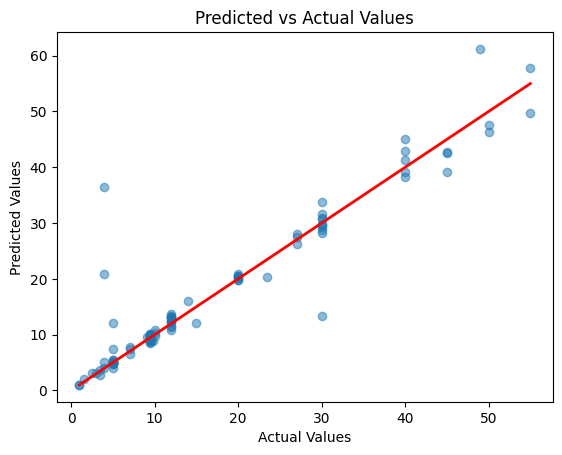

In [68]:
# validate with test data

import matplotlib.pyplot as plt

y_true = []
y_pred = []

RMSE = 0

with torch.no_grad():
    loss = 0
    for i, (inputs, labels) in enumerate(valid_loader):
        predictions = model(inputs)
        y_pred.extend(predictions.squeeze().numpy())
        y_true.extend(labels.squeeze().numpy())
        loss += F.mse_loss(predictions, labels)
    print(f'MSE Loss: {loss / (i + 1):.5f}')
    print(f'RMSE Loss: {math.sqrt(loss / (i + 1))}')
    RMSE = math.sqrt(loss / (i + 1))

# Assuming `y_true` is the actual target values and `y_pred` is the predicted values
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [69]:
now = datetime.now()
model_name = f'{str(round(RMSE, 2))} {now.strftime("%Y-%m-%d %H_%M")}' 
print(model_name)
torch.save(model.state_dict(), f'models/{model_name}.pt')



3.99 2025-01-15 17_55


In [27]:
# load model
model = nn.Sequential(
    nn.Linear(13665, 512), #13676 if including sex+tissue, 13665 if not
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8,1)
)

model_file = '2.7 2025-01-13 17_39' # ex/ '3.3 2024-10-30 15_51'
model.load_state_dict(torch.load(f'models/{model_file}.pt', weights_only=True))
model.eval()

Sequential(
  (0): Linear(in_features=13665, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=32, bias=True)
  (9): ReLU()
  (10): Linear(in_features=32, out_features=16, bias=True)
  (11): ReLU()
  (12): Linear(in_features=16, out_features=8, bias=True)
  (13): ReLU()
  (14): Linear(in_features=8, out_features=1, bias=True)
)

In [29]:
# determine feature importance 
def forward(inputs):
    return model(inputs)
        
feature_perm = FeaturePermutation(forward)
attributions = feature_perm.attribute(X_valid_tensor, target=0, show_progress=True)
feature_importance = torch.mean(torch.abs(attributions), dim=0)

Feature Permutation attribution: 100%|██████████| 13666/13666 [04:33<00:00, 49.94it/s]


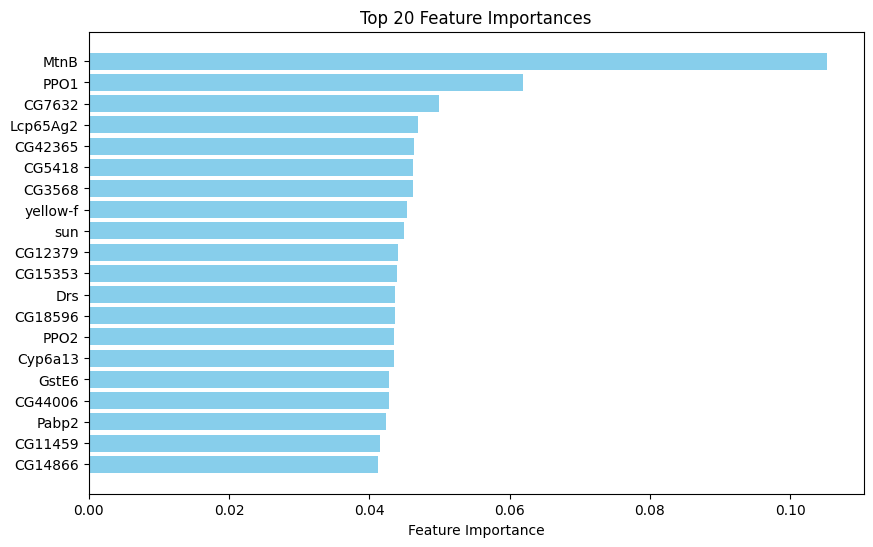

In [30]:
features = list(X.columns.values)
sorted_indices = np.argsort(feature_importance).tolist()
sorted_indices.reverse()
top_20_indices = sorted_indices[:20]
features_top20 = [features[i] for i in top_20_indices]
feature_importance_top20 = [feature_importance[i] for i in top_20_indices]

# Create a bar plot for the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(features_top20, feature_importance_top20, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis so the top feature is at the top
plt.show()

In [31]:
feature_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
feature_df = feature_df.iloc[sorted_indices]
feature_df.to_csv(f'models/feature importance/{model_file}.csv')
feature_list = list(feature_df['feature'])
with open(f'models/feature importance/{model_file}.txt', 'w') as f:
    for feature in feature_list:
        f.write(f"{feature}\n")
feature_df.head(10)


,feature,importance
10194,MtnB,0.105203
11295,PPO1,0.061888
6671,CG7632,0.049980
9589,Lcp65Ag2,0.046984
5111,CG42365,0.046379
6099,CG5418,0.046223
4889,CG3568,0.046176
13584,yellow-f,0.045412
12706,sun,0.044894
1569,CG12379,0.044147
